## BERT

### Import libraries

In [1]:
!pip install optuna

import pandas as pd
import numpy as np
import re
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Layer, Lambda
from tensorflow.keras.models import Model
import optuna
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


### Preprocessing module

In [2]:
# Loading the data
train_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv'
test_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv'

train_df = pd.read_csv(train_url, header=None)
test_df = pd.read_csv(test_url, header=None)

train_df.columns = ['Class Index', 'Title', 'Description']
test_df.columns = ['Class Index', 'Title', 'Description']
train_df['clean_text'] = train_df['Title'] + ' ' + train_df['Description']
test_df['clean_text'] = test_df['Title'] + ' ' + test_df['Description']

In [3]:
# Load the BERT tokenizer and define tokenization function
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def preprocess_for_bert(texts, max_len):
    """Tokenize text for BERT"""
    return tokenizer(
        texts.tolist(),
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='np'
    )

# Set maximum sequence length and preprocess text data
max_len = 128
X_train_bert = preprocess_for_bert(train_df['clean_text'], max_len)
X_test_bert = preprocess_for_bert(test_df['clean_text'], max_len)
y_train = train_df['Class Index'].values - 1
y_test = test_df['Class Index'].values - 1

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Basic training module

In [4]:
# Define custom layer for BERT embedding
class BertLayer(Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        output = self.bert(input_ids, attention_mask=attention_mask)
        return output.pooler_output

# Define model structure with custom BERT layer
input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')
bert_output = BertLayer()([input_ids, attention_masks])

# Add dense layers for classification
dense_1 = Dense(128, activation='relu')(bert_output)
dropout_1 = Dropout(0.3)(dense_1)
output = Dense(4, activation='softmax')(dropout_1)

# Compile the model
model = Model(inputs=[input_ids, attention_masks], outputs=output)
optimizer = Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the base model
model.fit(
    [X_train_bert['input_ids'], X_train_bert['attention_mask']], y_train,
    validation_split=0.1, epochs=5, batch_size=32, verbose=1,
    callbacks=[early_stopping])

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - accuracy: 0.4968 - loss: 1.1796 - val_accuracy: 0.7668 - val_loss: 0.7354
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/step - accuracy: 0.7577 - loss: 0.7106 - val_accuracy: 0.8079 - val_loss: 0.5619
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/step - accuracy: 0.8053 - loss: 0.5638 - val_accuracy: 0.8288 - val_loss: 0.4921
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/step - accuracy: 0.8241 - loss: 0.5031 - val_accuracy: 0.8340 - val_loss: 0.4681
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.8345 - loss: 0.4694 - val_accuracy: 0.8456 - val_loss: 0.4307


### Testing module 1

238/238 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step
Base Test Accuracy: 0.8466
Classification Report (Base Model):
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1900
           1       0.93      0.93      0.93      1900
           2       0.79      0.80      0.80      1900
           3       0.81      0.80      0.80      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600



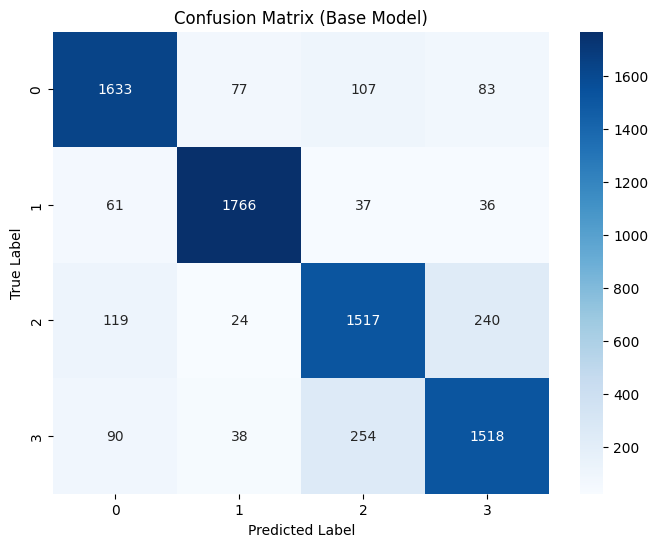

In [5]:
# Test the base model
y_pred = model.predict([X_test_bert['input_ids'], X_test_bert['attention_mask']])
y_pred_classes = y_pred.argmax(axis=1)
test_accuracy = (y_pred_classes == y_test).mean()
print(f'Base Test Accuracy: {test_accuracy:.4f}')
print("Classification Report (Base Model):")
print(classification_report(y_test, y_pred_classes))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Base Model)')
plt.show()

### Hyperparameter selection module

In [7]:
# Define model for Optuna hyperparameter tuning
def model_builder(trial):
    # Hyperparameters to optimize
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    num_units = trial.suggest_int('num_units', 64, 512)

    # Model structure with hyperparameter-optimized dense layers
    input_ids = Input(shape=(max_len,), dtype='int32', name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype='int32', name='attention_masks')
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')

    def bert_layer(inputs):
        return bert_model(inputs[0], attention_mask=inputs[1]).pooler_output

    bert_output = Lambda(bert_layer, output_shape=(768,))([input_ids, attention_masks])
    dense_1 = Dense(num_units, activation='relu')(bert_output)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    output = Dense(4, activation='softmax')(dropout_1)

    # Compile the model with optimized learning rate
    model = Model(inputs=[input_ids, attention_masks], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Objective function for Optuna
def objective(trial):
    model = model_builder(trial)
    model.fit([X_train_bert['input_ids'], X_train_bert['attention_mask']], y_train,
              validation_split=0.1, epochs=3, batch_size=32, verbose=1)
    loss, accuracy = model.evaluate([X_test_bert['input_ids'], X_test_bert['attention_mask']], y_test, verbose=1)
    return accuracy

# Run Optuna hyperparameter optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
print(study.best_trial)

[I 2024-10-29 11:12:40,002] A new study created in memory with name: no-name-226a06fd-c1eb-4c2b-9d0b-fa11d54d9e3e
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is

Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 78s 18ms/step - accuracy: 0.5330 - loss: 1.1169 - val_accuracy: 0.7746 - val_loss: 0.6949
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.7748 - loss: 0.6678 - val_accuracy: 0.8137 - val_loss: 0.5467
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.8118 - loss: 0.5475 - val_accuracy: 0.8276 - val_loss: 0.4873
238/238 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.8243 - loss: 0.5017


[I 2024-10-29 11:16:07,289] Trial 0 finished with value: 0.828026294708252 and parameters: {'dropout_rate': 0.26800203725737265, 'learning_rate': 1.633359197678417e-05, 'num_units': 508}. Best is trial 0 with value: 0.828026294708252.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a Bert

Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.5890 - loss: 1.0151 - val_accuracy: 0.8158 - val_loss: 0.5528
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/step - accuracy: 0.8135 - loss: 0.5391 - val_accuracy: 0.8337 - val_loss: 0.4613
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.8362 - loss: 0.4652 - val_accuracy: 0.8482 - val_loss: 0.4197
238/238 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.8434 - loss: 0.4404


[I 2024-10-29 11:19:36,466] Trial 1 finished with value: 0.8489473462104797 and parameters: {'dropout_rate': 0.2747146590641347, 'learning_rate': 3.45422300709503e-05, 'num_units': 439}. Best is trial 1 with value: 0.8489473462104797.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a Bert

Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.4397 - loss: 1.2475 - val_accuracy: 0.6829 - val_loss: 0.9558
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 56s 16ms/step - accuracy: 0.6733 - loss: 0.9231 - val_accuracy: 0.7482 - val_loss: 0.7799
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/step - accuracy: 0.7364 - loss: 0.7728 - val_accuracy: 0.7788 - val_loss: 0.6709
238/238 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.7715 - loss: 0.6773


[I 2024-10-29 11:23:06,629] Trial 2 finished with value: 0.7747368216514587 and parameters: {'dropout_rate': 0.2548399329408946, 'learning_rate': 1.109657261938775e-05, 'num_units': 130}. Best is trial 1 with value: 0.8489473462104797.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a Ber

Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.5064 - loss: 1.1514 - val_accuracy: 0.7774 - val_loss: 0.6781
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.7583 - loss: 0.6788 - val_accuracy: 0.8133 - val_loss: 0.5336
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.8036 - loss: 0.5569 - val_accuracy: 0.8312 - val_loss: 0.4749
238/238 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8282 - loss: 0.4869


[I 2024-10-29 11:26:35,208] Trial 3 finished with value: 0.8317105174064636 and parameters: {'dropout_rate': 0.4815933294236351, 'learning_rate': 4.46085313595178e-05, 'num_units': 127}. Best is trial 1 with value: 0.8489473462104797.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a Bert

Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.5278 - loss: 1.1494 - val_accuracy: 0.7517 - val_loss: 0.7715
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.7616 - loss: 0.7258 - val_accuracy: 0.8019 - val_loss: 0.6023
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/step - accuracy: 0.8017 - loss: 0.5908 - val_accuracy: 0.8223 - val_loss: 0.5246
238/238 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8174 - loss: 0.5383


[I 2024-10-29 11:30:02,856] Trial 4 finished with value: 0.8213157653808594 and parameters: {'dropout_rate': 0.07259883055039529, 'learning_rate': 1.497368096620224e-05, 'num_units': 252}. Best is trial 1 with value: 0.8489473462104797.


FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.8489473462104797], datetime_start=datetime.datetime(2024, 10, 29, 11, 16, 7, 290021), datetime_complete=datetime.datetime(2024, 10, 29, 11, 19, 36, 466304), params={'dropout_rate': 0.2747146590641347, 'learning_rate': 3.45422300709503e-05, 'num_units': 439}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'learning_rate': FloatDistribution(high=5e-05, log=True, low=1e-05, step=None), 'num_units': IntDistribution(high=512, log=False, low=64, step=1)}, trial_id=1, value=None)


### Testing module 2

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 73s 18ms/step - accuracy: 0.5767 - loss: 1.0297 - val_accuracy: 0.8029 - val_loss: 0.5739
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 55s 16ms/step - accuracy: 0.8069 - loss: 0.5556 - val_accuracy: 0.8279 - val_loss: 0.4792
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 55s 16ms/step - accuracy: 0.8348 - loss: 0.4677 - val_accuracy: 0.8444 - val_loss: 0.4340
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.8467 - loss: 0.4357 - val_accuracy: 0.8526 - val_loss: 0.4029
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.8545 - loss: 0.4145 - val_accuracy: 0.8596 - val_loss: 0.3885
238/238 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step
Optimized Test Accuracy: 0.8589
Classification Report (Optimized Model):
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1900
           1       0.93      0.95      0.94      1900
           2       0.78      0.84      0.81      1900
           3

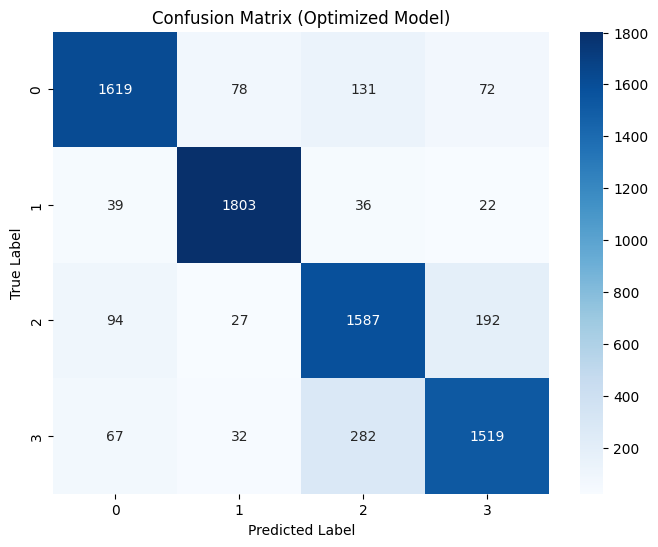

In [8]:
# Load and build best model from Optuna study
best_trial = study.best_trial
model = model_builder(best_trial)

# Train model with best hyperparameters
model.fit([X_train_bert['input_ids'], X_train_bert['attention_mask']], y_train,
          validation_split=0.1, epochs=5, batch_size=32, verbose=1)

# Test the optimized model
y_pred = model.predict([X_test_bert['input_ids'], X_test_bert['attention_mask']])
y_pred_classes = y_pred.argmax(axis=1)
test_accuracy = (y_pred_classes == y_test).mean()
print(f'Optimized Test Accuracy: {test_accuracy:.4f}')
print("Classification Report (Optimized Model):")
print(classification_report(y_test, y_pred_classes))

# Display confusion matrix for optimized model
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Optimized Model)')
plt.show()